In [1]:
import os
import shutil
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 1. 数据划分
def split_data(data_dir, train_size=0.8, random_state=42):
    categories = ['Fire', 'No_Fire']

    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith('.jpg')]

        train_images, test_images = train_test_split(images, test_size=1-train_size, random_state=random_state)

        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(test_category_dir, exist_ok=True)

        for train_img in train_images:
            shutil.move(train_img, train_category_dir)
        for test_img in test_images:
            shutil.move(test_img, test_category_dir)

    print("Dataset has been split into train and test sets.")

# 2. 数据预处理和加载
def get_data_loaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
    test_data = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# 3. 构建模型
def build_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# 4. 训练模型
def train_model(model, train_loader, device, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    
    # 用于记录损失和准确率
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return train_losses, train_accuracies

# 5. 测试模型
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# 6. 绘制损失和准确率曲线
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'go-', label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Curve')
    plt.legend()

    plt.show()


Dataset has been split into train and test sets.


/root/miniconda3/envs/myconda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.1019, Accuracy: 96.53%
Epoch 2/10, Loss: 0.0463, Accuracy: 98.77%
Epoch 3/10, Loss: 0.0308, Accuracy: 99.09%
Epoch 4/10, Loss: 0.0387, Accuracy: 98.68%
Epoch 5/10, Loss: 0.0236, Accuracy: 99.30%
Epoch 6/10, Loss: 0.0150, Accuracy: 99.61%
Epoch 7/10, Loss: 0.0088, Accuracy: 99.77%
Epoch 8/10, Loss: 0.0142, Accuracy: 99.52%
Epoch 9/10, Loss: 0.0181, Accuracy: 99.41%
Epoch 10/10, Loss: 0.0156, Accuracy: 99.56%
Test Accuracy: 98.72%


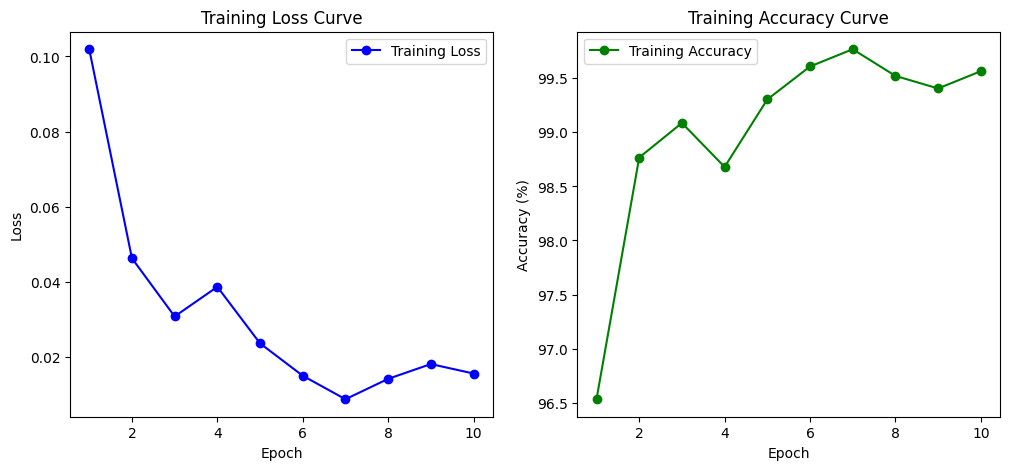

Model saved as 'fire_nofire_model.pth'.


In [2]:
data_dir = 'Test'

split_data(data_dir)
train_loader, test_loader = get_data_loaders(data_dir)
model = build_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 训练模型并记录损失和准确率
train_losses, train_accuracies = train_model(model, train_loader, device, num_epochs=10, lr=0.001)

# 测试模型
test_accuracy = evaluate_model(model, test_loader, device)

# 绘制训练损失和准确率曲线
plot_metrics(train_losses, train_accuracies)

# 保存模型
torch.save(model.state_dict(), 'fire_nofire_model.pth')
print("Model saved as 'fire_nofire_model.pth'.")